In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

C:\Users\jamesl\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# read csv with specified date column, drop unnecessary columns
df = pd.read_csv(
    "./data/super_rugby_oddsportal.csv", parse_dates =["Date"]
).drop(
    ['Play-off Game?', 'Bookmakers Surveyed'], axis=1  # drop unnecessary columns
).sort_values(
    'Date', ascending=False  # sort by date
).reset_index(drop=True).dropna()

df.head(15)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds
0,2020-03-07,Hurricanes,Blues,0,0,1.42,24.68,2.91
1,2020-03-07,Rebels,Lions,0,0,1.49,23.24,2.63
2,2020-03-07,Sharks,Jaguares,0,0,1.55,21.84,2.51
3,2020-03-07,Bulls,Highlanders,0,0,1.74,22.04,2.11
4,2020-03-06,Sunwolves,Brumbies,0,0,14.63,48.56,1.01
5,2020-03-06,Waratahs,Chiefs,0,0,3.54,25.87,1.29
6,2020-03-06,Crusaders,Reds,0,0,1.04,42.71,10.76
7,2020-02-29,Hurricanes,Sunwolves,62,15,1.01,50.80,19.30
8,2020-02-29,Reds,Sharks,23,33,1.84,21.18,1.98
9,2020-02-29,Stormers,Blues,14,33,1.30,22.39,3.55


In [3]:
# number of upcoming fixtures
n_matches = len(df[(df['Home Score']==0) & (df['Away Score']==0)])

---
# 1. Feature engineering
## Categorical columns
  - avg points scored by home side in last n games
  - avg points conceded by home side in last n games
  - avg points scored by away side in last n games
  - avg points conceded by away side in last n games

In [5]:
# standardise naming format
df.columns = [x.lower().replace(' ', '_') for x in df.columns]

countries = {'Crusaders': 'NZ',
             'Chiefs': 'NZ',
             'Blues': 'NZ',
             'Hurricanes': 'NZ',
             'Highlanders': 'NZ',
             'Bulls': 'SA',
             'Cheetahs': 'SA',
             'Kings': 'SA',
             'Lions': 'SA',
             'Sharks': 'SA',
             'Stormers': 'SA',
             'Brumbies': 'AUS',
             'Force': 'AUS',
             'Rebels': 'AUS',
             'Reds': 'AUS',
             'Waratahs': 'AUS',
             'Jaguares': 'ARG',
             'Sunwolves': 'JPN'}

# add nationalities
df['home_country'] = df['home_team'].replace(countries)
df['away_country'] = df['away_team'].replace(countries)

# extract year
df['year'] = df['date'].apply(lambda x: x.year)

# convert to pandas category dtypes
df[
    ['home_team', 'away_team', 'home_country', 'away_country']
] = df[
    ['home_team', 'away_team', 'home_country', 'away_country']
].astype('category')

df.head()

,date,home_team,away_team,home_score,away_score,home_odds,draw_odds,away_odds,home_country,away_country,year
0,2020-03-07,Hurricanes,Blues,0,0,1.42,24.68,2.91,NZ,NZ,2020
1,2020-03-07,Rebels,Lions,0,0,1.49,23.24,2.63,AUS,SA,2020
2,2020-03-07,Sharks,Jaguares,0,0,1.55,21.84,2.51,SA,ARG,2020
3,2020-03-07,Bulls,Highlanders,0,0,1.74,22.04,2.11,SA,NZ,2020
4,2020-03-06,Sunwolves,Brumbies,0,0,14.63,48.56,1.01,JPN,AUS,2020


## Window functions
  - avg points scored by home side in last n games
  - avg points conceded by home side in last n games
  - avg points scored by away side in last n games
  - avg points conceded by away side in last n games

In [6]:
# add home margin column
df['home_margin'] = df['home_score'] - df['away_score']
# add home win column
df['home_win'] = (df['home_score'] > df['away_score']).astype('int')

# aggregate odds into single probability variable
df['home_odds'] = df['away_odds'] / (df['home_odds'] + df['away_odds'])
df.drop(['draw_odds', 'away_odds'], axis=1, inplace=True)

df.head(15)

,date,home_team,away_team,home_score,away_score,home_odds,home_country,away_country,year,home_margin,home_win
0,2020-03-07,Hurricanes,Blues,0,0,0.672055,NZ,NZ,2020,0,0
1,2020-03-07,Rebels,Lions,0,0,0.638350,AUS,SA,2020,0,0
2,2020-03-07,Sharks,Jaguares,0,0,0.618227,SA,ARG,2020,0,0
3,2020-03-07,Bulls,Highlanders,0,0,0.548052,SA,NZ,2020,0,0
4,2020-03-06,Sunwolves,Brumbies,0,0,0.064578,JPN,AUS,2020,0,0
5,2020-03-06,Waratahs,Chiefs,0,0,0.267081,AUS,NZ,2020,0,0
6,2020-03-06,Crusaders,Reds,0,0,0.911864,NZ,AUS,2020,0,0
7,2020-02-29,Hurricanes,Sunwolves,62,15,0.950271,NZ,JPN,2020,47,1
8,2020-02-29,Reds,Sharks,23,33,0.518325,AUS,SA,2020,-10,0
9,2020-02-29,Stormers,Blues,14,33,0.731959,SA,NZ,2020,-19,0


In [7]:
df = df.assign(
    # average odds for home_team in previous n home fixtures
    avg_hm_odd_5=df.groupby('home_team')['home_odds'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_hm_odd_10=df.groupby('home_team')['home_odds'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_hm_odd_20=df.groupby('home_team')['home_odds'].rolling(20).mean().shift(-20).reset_index(0, drop=True),
    # average odds for away team in previous n away fixtures
    avg_aw_odd_5= 1-df.groupby('away_team')['home_odds'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_aw_odd_10= 1-df.groupby('away_team')['home_odds'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_aw_odd_20= 1-df.groupby('away_team')['home_odds'].rolling(20).mean().shift(-20).reset_index(0, drop=True),
    # home team win rate previous n
    hm_wr_5=df.groupby('home_team')['home_win'].rolling(5).sum().shift(-5).reset_index(0, drop=True)/5,
    hm_wr_10=df.groupby('home_team')['home_win'].rolling(10).sum().shift(-10).reset_index(0, drop=True)/10,
    hm_wr_20=df.groupby('home_team')['home_win'].rolling(20).sum().shift(-20).reset_index(0, drop=True)/20,
    # away team win rate previous n
    aw_wr_5= 1-df.groupby('away_team')['home_win'].rolling(5).sum().shift(-5).reset_index(0, drop=True)/5,
    aw_wr_10= 1-df.groupby('away_team')['home_win'].rolling(10).sum().shift(-10).reset_index(0, drop=True)/10,
    aw_wr_20= 1-df.groupby('away_team')['home_win'].rolling(20).sum().shift(-20).reset_index(0, drop=True)/20,
    # average margin by home_team in previous n home fixtures
    avg_hm_marg_5=df.groupby('home_team')['home_margin'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_hm_marg_10=df.groupby('home_team')['home_margin'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_hm_marg_20=df.groupby('home_team')['home_margin'].rolling(20).mean().shift(-20).reset_index(0, drop=True)
)

df = df.dropna().reset_index(drop=True)

df.head(15)

,date,home_team,away_team,home_score,away_score,home_odds,home_country,away_country,year,home_margin,home_win,avg_hm_odd_5,avg_hm_odd_10,avg_hm_odd_20,avg_aw_odd_5,avg_aw_odd_10,avg_aw_odd_20,hm_wr_5,hm_wr_10,hm_wr_20,aw_wr_5,aw_wr_10,aw_wr_20,avg_hm_marg_5,avg_hm_marg_10,avg_hm_marg_20
0,2020-03-07,Hurricanes,Blues,0,0,0.672055,NZ,NZ,2020,0,0,0.692555,0.665767,0.739463,0.478585,0.437561,0.401936,1.0,0.7,0.85,0.6,0.3,0.30,15.6,6.0,8.65
1,2020-03-07,Rebels,Lions,0,0,0.638350,AUS,SA,2020,0,0,0.614704,0.627721,0.557811,0.294272,0.426571,0.461474,0.6,0.5,0.45,0.0,0.3,0.35,-1.2,-4.5,-3.05
2,2020-03-07,Sharks,Jaguares,0,0,0.618227,SA,ARG,2020,0,0,0.640400,0.626629,0.638982,0.293217,0.332423,0.302508,0.4,0.5,0.60,0.2,0.6,0.50,-7.2,0.5,3.75
3,2020-03-07,Bulls,Highlanders,0,0,0.548052,SA,NZ,2020,0,0,0.477962,0.593841,0.564104,0.218036,0.393885,0.476594,0.4,0.4,0.50,0.2,0.2,0.30,-1.0,-5.7,-0.05
4,2020-03-06,Sunwolves,Brumbies,0,0,0.064578,JPN,AUS,2020,0,0,0.202183,0.243343,0.226733,0.258022,0.395699,0.361580,0.2,0.1,0.25,0.4,0.4,0.35,-27.4,-17.3,-13.85
5,2020-03-06,Waratahs,Chiefs,0,0,0.267081,AUS,NZ,2020,0,0,0.585862,0.600123,0.567216,0.477945,0.431569,0.457903,0.4,0.4,0.50,0.6,0.6,0.60,-3.2,-1.7,4.10
6,2020-03-06,Crusaders,Reds,0,0,0.911864,NZ,AUS,2020,0,0,0.852486,0.832100,0.825995,0.280836,0.271399,0.274829,1.0,1.0,0.95,0.0,0.2,0.15,31.8,23.3,20.90
7,2020-02-29,Hurricanes,Sunwolves,62,15,0.950271,NZ,JPN,2020,47,1,0.659363,0.654802,0.729098,0.143203,0.154683,0.119771,0.8,0.7,0.85,0.0,0.3,0.15,4.6,1.9,6.90
8,2020-02-29,Reds,Sharks,23,33,0.518325,AUS,SA,2020,-10,0,0.535191,0.510963,0.428757,0.402272,0.371348,0.353326,0.6,0.6,0.55,0.4,0.5,0.40,10.6,6.5,3.45
9,2020-02-29,Stormers,Blues,14,33,0.731959,SA,NZ,2020,-19,0,0.695486,0.618988,0.611576,0.461002,0.455718,0.435451,0.8,0.7,0.75,0.4,0.2,0.25,12.0,9.8,9.90


---
# 2. Train model

In [8]:
team_le = LabelEncoder()
df['home_team'] = team_le.fit_transform(df['home_team'])
df['away_team'] = team_le.fit_transform(df['away_team'])

country_le = LabelEncoder()
df['home_country'] = country_le.fit_transform(df['home_country'])
df['away_country'] = country_le.fit_transform(df['away_country'])

In [10]:
X = df[n_matches:].drop(['date', 'home_score', 'away_score', 'home_margin', 'home_win'], axis=1)
y = df[n_matches:].home_margin.values

In [11]:
# upcoming week's fixtures:
X_temp = df[:n_matches].drop(['date', 'home_score', 'away_score', 'home_margin', 'home_win'], axis=1)
y_temp = df[:n_matches].home_margin.values

In [12]:
X.shape

(953, 21)

In [13]:
y.shape

(953,)

In [14]:
# set up train/test split with 80/20 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True)

In [15]:
X_train.head()

,home_team,away_team,home_odds,home_country,away_country,year,avg_hm_odd_5,avg_hm_odd_10,avg_hm_odd_20,avg_aw_odd_5,avg_aw_odd_10,avg_aw_odd_20,hm_wr_5,hm_wr_10,hm_wr_20,aw_wr_5,aw_wr_10,aw_wr_20,avg_hm_marg_5,avg_hm_marg_10,avg_hm_marg_20
172,14,15,0.676538,4,4,2019,0.637813,0.653834,0.671765,0.382112,0.441563,0.492320,1.0,0.8,0.70,0.0,0.2,0.35,15.0,8.0,5.9
504,5,7,0.743487,3,3,2015,0.699190,0.751481,0.751055,0.477544,0.359328,0.367627,0.8,0.8,0.75,0.8,0.5,0.40,19.6,17.5,13.4
118,4,0,0.641827,3,3,2019,0.575309,0.662461,0.696069,0.362860,0.405208,0.444718,0.4,0.6,0.70,0.2,0.3,0.30,-1.8,1.9,5.6
411,15,4,0.400000,4,3,2016,0.739613,0.681317,0.666699,0.540948,0.490233,0.480015,0.8,0.7,0.70,0.6,0.6,0.50,14.2,8.7,8.9
229,13,7,0.260081,1,3,2018,0.261460,0.435194,0.424723,0.613371,0.573572,0.557862,0.4,0.5,0.40,0.4,0.5,0.50,-4.8,-2.5,-5.2


### Evaluate performance

In [16]:
model = XGBRegressor(max_depth=1, learning_rate=.1, n_estimators=100, n_jobs=-1, min_child_weight=5, subsample=.45, random_state=0)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.45, tree_method=None,
             validate_parameters=False, verbosity=None)

In [17]:
# training data
print(f'Train RMSE: {np.sqrt(mean_squared_error(model.predict(X_train), y_train)):.3f}')
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.3f}')

Train RMSE: 13.70040
Train MAE: 10.57056


In [19]:
# test data
print(f'Test RMSE: {np.sqrt(mean_squared_error(model.predict(X_test), y_test)):.3f}')
print(f'Test MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}')

Test RMSE: 13.879
Test MAE: 11.033


### Train on all data (if not overfitting)

In [18]:
# include feature standardizer to numeric columns

# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# # standardize first two columns
# ct = ColumnTransformer(
#     [('scaler', StandardScaler(), [0, 1, -1])]
# )

# xgb = XGBRegressor(max_depth=1, learning_rate=.1, n_estimators=100, n_jobs=-1, min_child_weight=5, subsample=.45, random_state=0)

# model = Pipeline(
#     [
#         ('transformer', ct),
#         ('regressor', xgb)        
#     ]
# )

In [20]:
model.fit(X, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.45, tree_method=None,
             validate_parameters=False, verbosity=None)

In [21]:
model.fit(X, y)

print(f'RMSE: {np.sqrt(mean_squared_error(model.predict(X), y)):.5f}')
print(f'MAE: {mean_absolute_error(y, model.predict(X)):.5f}')

RMSE: 13.73555
MAE: 10.65472


### SHAP values
[Here is a nice notebook tutorial](https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html)  for working with SHAP values.

In [23]:
import shap
shap.initjs()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


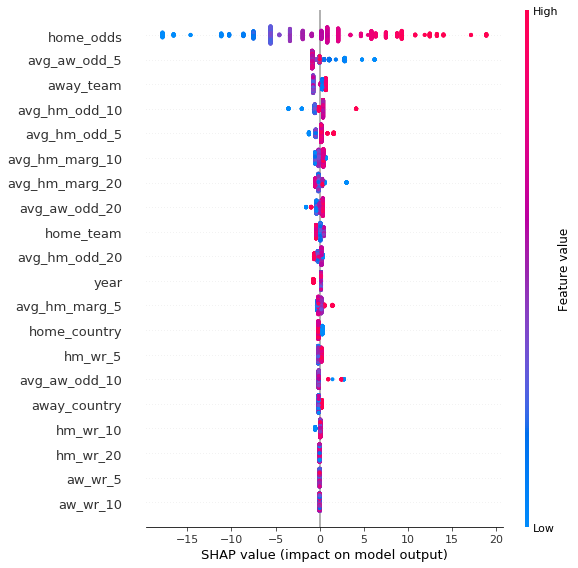

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

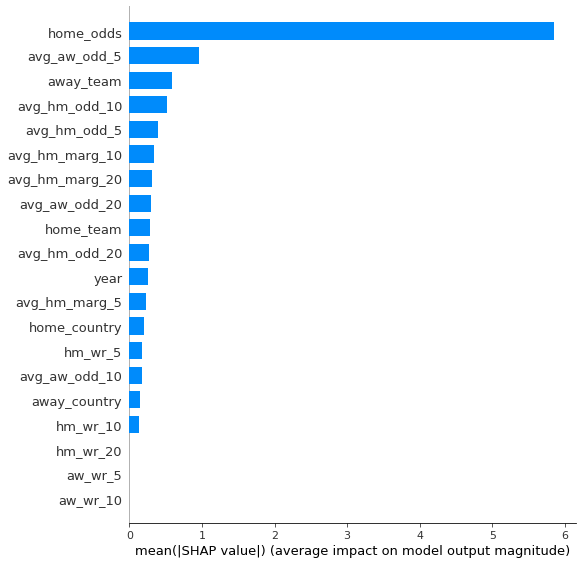

In [25]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [26]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

## 5. Make predictions for upcoming week

In [33]:
temp = np.vstack((model.predict(X_temp), df['home_team'][:n_matches], df['away_team'][:n_matches])).T

In [34]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [37]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df['Home_Team'] = team_le.inverse_transform(preds_df['Home_Team'].astype('int'))
preds_df['Away_Team'] = team_le.inverse_transform(preds_df['Away_Team'].astype('int'))
preds_df

,Home_Margin,Home_Team,Away_Team
0,3,Hurricanes,Blues
1,4,Rebels,Lions
2,2,Sharks,Jaguares
3,1,Bulls,Highlanders
4,-15,Sunwolves,Brumbies
5,-8,Waratahs,Chiefs
6,31,Crusaders,Reds


### Explain single prediction

In [38]:
MATCH_NO = 6

print(f'Explaining result of  {preds_df.iloc[MATCH_NO,1]} vs {preds_df.iloc[MATCH_NO,2]}:\n')
shap_values = explainer.shap_values(X_temp)
shap.force_plot(explainer.expected_value, shap_values[MATCH_NO,:], X_temp.iloc[MATCH_NO,:])

Explaining result of  Crusaders vs Reds:

